# Summary

> **TL;DR:** *Slant* terms are a rotational transformation of the horizontal coordinate system to one referenced to a sight line.

We often think of distance or location in horizontal and vertical terms that are referenced to the direction of gravity.  The *map distance* to a target ignores any variation in altitude, and *height* is measured perpendicular to the horizontal plane.

When a target is not at the same altitude as a shooter, there is an angle between the horizontal and the *line of sight* to the target.  This *sight angle*, or *slant angle*, is also called *look angle*, and in military literature is often (misspelled) *angle of site*.

For some purposes this *slant frame of reference* can be more convenient than the horizontal frame.  For example, when computing *point-blank range* or *danger space*, or when adjusting sights, it is the *slant height* that matters.  Basic ranging techniques typically return the *slant-distance* to a target.

In this document we will start with the standard horizontal frame and then show how to convert between a slant frame.

In [1]:
# LOAD ME
import logging
import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from py_ballisticcalc import Shot, DragModel, Ammo, Velocity, Weight, Distance, TableG7, TableGS
from py_ballisticcalc import Calculator, loadMetricUnits, logger
from py_ballisticcalc import PreferredUnits, TrajFlag, Angular
logger.setLevel(logging.WARNING)
loadMetricUnits()
PreferredUnits.drop = Distance.Meter
calc = Calculator(engine="scipy_engine")

# Horizontal frame

**Gravity gives $y$:** In ballistics, everything is referenced to the direction of gravity. The gravity vector points "down," and this defines the vertical direction. In 3D Cartesian coordinates $(x, y, z)$, the gravity vector is $(0, -g, 0)$, where $g$ is acceleration due to gravity (typically 32 feet/second² or 9.8 meters/second²). The $y$ coordinate describes vertical (up/down) position.

**Horizontal:** Having defined the vertical axis using the gravity vector, we can then define *horizontal* as any vector perpendicular (or *orthogonal*) to the direction of gravity.

**Sight gives $x$:** The second key reference in ballistics is the **sight line**. We set the origin of our coordinate system $(0, 0, 0)$ at the sight, which is usually either the shooter’s eye or the center of a sighting device like a scope. The *sight line* is the ray starting at the origin and pointing in the exact direction of the sight.  The $x$ coordinate measures distance from the sight along a horizontal sight line.

The $z$ coordinate describes position orthogonal to both the direction of gravity and the sight line. From the perspective of the sight, this is lateral position, also known as windage.

## Diagram

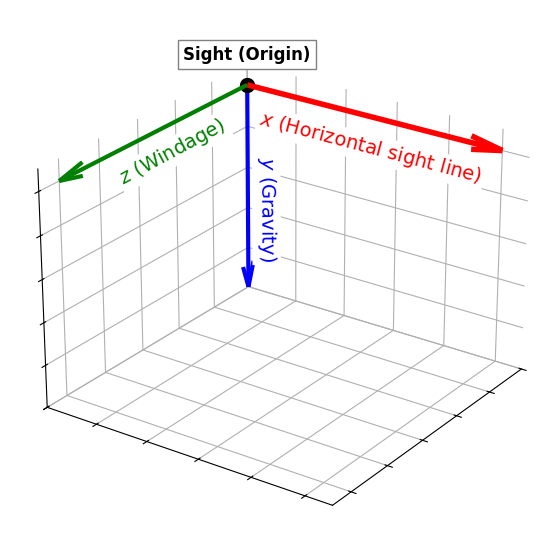

In [2]:
# Create illustration of ballistic coordinate system
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=25, azim=35)
arrow_length = 1.0
# "x" is plot-y, "y" is plot-z, "z" is plot-x
ax.quiver(0, 0, 1, 0, arrow_length, 0, color='red', linewidth=4, arrow_length_ratio=0.12)
ax.text(0, 0.5, 0.85, '$x$ (Horizontal sight line)', color='red', fontsize=14, zdir='y', va='center', ha='center',
        bbox=dict(facecolor='white', edgecolor='none', pad=2))
ax.quiver(0, 0, 1, 0, 0, -arrow_length, color='blue', linewidth=3, arrow_length_ratio=0.12)
ax.text(0.1, 0.1, 0.47, '$y$ (Gravity)', color='blue', fontsize=14, zdir='z', va='center', ha='left',
        bbox=dict(facecolor='white', edgecolor='none', pad=2))
ax.quiver(0, 0, 1, arrow_length, 0, 0, color='green', linewidth=3, arrow_length_ratio=0.12)
ax.text(0.1, 0, 0.72, '$z$ (Windage)', color='green', fontsize=14, zdir='x', va='center', ha='right',
        bbox=dict(facecolor='white', edgecolor='none', pad=2))
# Origin
ax.scatter(0, 0, 1, color='black', s=100)
ax.text(0, 0., 1.1, 'Sight (Origin)', color='black', fontsize=12, fontweight='bold', va='bottom', ha='center',
        bbox=dict(facecolor='white', edgecolor='gray', pad=4))
# Crop axes tightly to arrows
ax.set_xlim([0, arrow_length*1.1])
ax.set_ylim([0, arrow_length*1.1])
ax.set_zlim([0, arrow_length*1.1])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.grid(True)
#ax.set_title('Ballistics Coordinate System', fontsize=16)
#plt.savefig('ballistics_coordinate_system.svg', bbox_inches='tight')
plt.show()

# Simple Trajectory

Imagine you're looking at a target 1km away across level ground (meaning your sight line is horizontal).  We'll model a standard 7.62mm NATO round, then use our calculator to find the barrel elevation needed for that round to hit the target, then plot the trajectory.

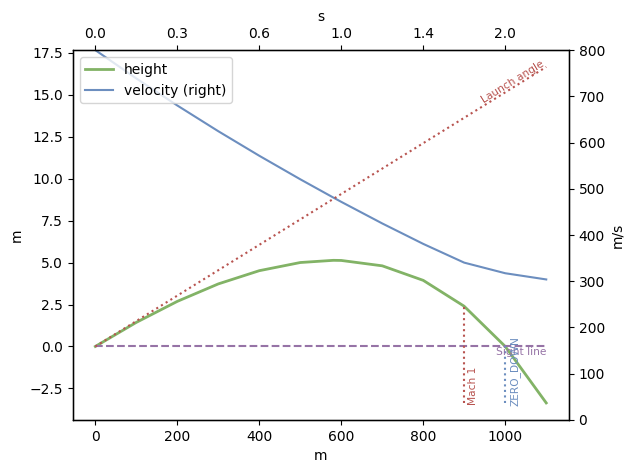

In [3]:
calc = Calculator(engine="euler_engine")
def create_7_62_mm_shot():  # 7.62x51mm NATO M118   
    dm = DragModel(bc=0.243, drag_table=TableG7, weight=Weight.Grain(175), diameter=Distance.Millimeter(7.62), length=Distance.Millimeter(32.0))
    return Shot(ammo=Ammo(dm, mv=Velocity.MPS(800)))
shot = create_7_62_mm_shot()
calc.set_weapon_zero(shot, zero_distance=Distance.Meter(1000))
t = calc.fire(shot, trajectory_range=Distance.Meter(1100), trajectory_step=Distance.Meter(100), extra_data=True)
t.plot()
plt.show()

## Table

Here is a table showing some of the details the calculator generates for points along the trajectory:

In [4]:
df = t.dataframe(True).drop(columns=['drop_adj', 'windage', 'windage_adj', 'density_ratio', 'drag', 'ogw'])
df#[df.distance.str.contains("00.") | (df.flag != "RANGE")]

,time,distance,velocity,mach,height,slant_height,slant_distance,angle,energy,flag
0,0.000 s,0.0 m,800 m/s,2.35 mach,-0.0 m,-0.0 m,0.0 m,0.8676 °,3629 J,RANGE
1,0.130 s,100.0 m,739 m/s,2.17 mach,1.4 m,1.4 m,100.0 m,0.7725 °,3094 J,RANGE
2,0.271 s,200.0 m,680 m/s,2.00 mach,2.7 m,2.7 m,200.0 m,0.6606 °,2623 J,RANGE
3,0.425 s,300.0 m,624 m/s,1.84 mach,3.7 m,3.7 m,300.0 m,0.5282 °,2211 J,RANGE
4,0.592 s,400.0 m,571 m/s,1.68 mach,4.5 m,4.5 m,400.0 m,0.3705 °,1851 J,RANGE
5,0.776 s,500.0 m,520 m/s,1.53 mach,5.0 m,5.0 m,500.0 m,0.1814 °,1536 J,RANGE
6,0.937 s,580.8 m,481 m/s,1.41 mach,5.1 m,5.1 m,580.8 m,-0.0002 °,1311 J,APEX
7,0.977 s,600.0 m,472 m/s,1.39 mach,5.1 m,5.1 m,600.0 m,-0.0477 °,1261 J,RANGE
8,1.201 s,700.0 m,425 m/s,1.25 mach,4.8 m,4.8 m,700.0 m,-0.3285 °,1023 J,RANGE
9,1.450 s,800.0 m,381 m/s,1.12 mach,3.9 m,3.9 m,800.0 m,-0.6765 °,821 J,RANGE


Some of these rows look duplicative.  "distance" and "slant_distance" are always the same, as are "height" and "slant_height."  We'll get into scenarios where those differ soon.  First, let's look at what the row corresponding to the APEX flag tells us:

In [5]:
df[df.flag == "APEX"]

,time,distance,velocity,mach,height,slant_height,slant_distance,angle,energy,flag
6,0.937 s,580.8 m,481 m/s,1.41 mach,5.1 m,5.1 m,580.8 m,-0.0002 °,1311 J,APEX


We define the apex of a trajectory as the point where vertical velocity goes from positive to negative.  This is equivalent to saying that the trajectory's angle is horizontal (i.e., 0°).  When present, the apex is the highest point in the trajectory.  In this example, it occurs at a distance 580m along the sight line, and at that point the projectile is 5.1m above the sight line.

Another special point, which is also depicted on the chart, is the Mach crossing.  This occurs later in the trajectory while the projectile is 899m along the sight line and 2.4m above it:

In [6]:
df[df.flag == "MACH"]

,time,distance,velocity,mach,height,slant_height,slant_distance,angle,energy,flag
10,1.726 s,899.3 m,340 m/s,1.00 mach,2.4 m,2.4 m,899.3 m,-1.1085 °,656 J,MACH


# Non-zero look-angle

So far we have been considering horizontal sight lines.  What happens if the shooter is looking at a target at a different altitude?

Let's imagine you have a friend on the roof of a tall building and you want to launch a ball for him to catch.  The building is 100m away on level ground, and he – the target – is 100m above the ground.  In a case like this it can be more intuitive to talk about the angle and straight-line distance to the target, which we can get from trigonometry:

In [7]:
horizontal_distance = 100.
altitude = 100.
slant_angle = Angular.Radian(math.atan2(altitude, horizontal_distance))
slant_distance = np.hypot(horizontal_distance, altitude)
print(f'Slant angle to target is {slant_angle >> Angular.Degree} degrees. Slant range is {slant_distance:.1f}.')

Slant angle to target is 45.0 degrees. Slant range is 141.4.


The sight-line to this target is 45 degrees above the horizontal, and its distance along the sight line (the slant range) is 141.4m.  Let's suppose we have a gun that launches a ball at 55m/s and solve for the trajectory to get the ball to your friend:

Launch angle to hit the target is 63.3 degrees.


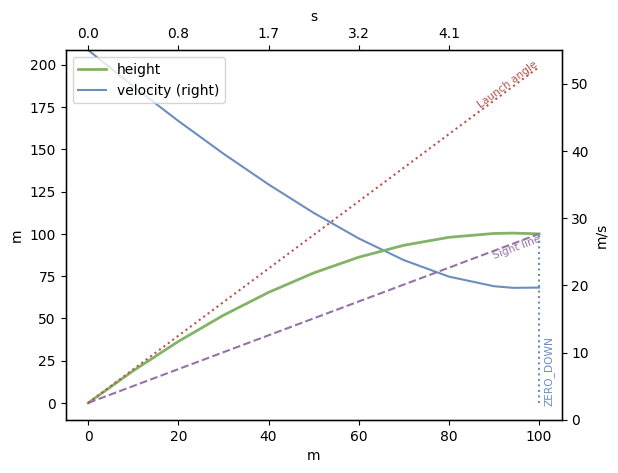

In [8]:
def create_ball_shot():
    dm = DragModel(bc=0.2, drag_table=TableGS)  # GS model is used for spherical projectiles
    return Shot(ammo=Ammo(dm, mv=Velocity.MPS(55)))
shot = create_ball_shot()
shot.look_angle = slant_angle  # Set the look-angle to the one we calculated
calc.set_weapon_zero(shot, zero_distance=Distance.Meter(slant_distance))
print(f'Launch angle to hit the target is {shot.barrel_elevation >> Angular.Degree:.1f} degrees.')
tball = calc.fire(shot, trajectory_range=Distance.Meter(100), trajectory_step=Distance.Meter(10), extra_data=True)
ax = tball.plot()
plt.show()

## Table

Now when we look at the detailed data we see that the "slant_distance" is always greater than the "distance," and the "slant_height" is always less than the "height."

In [9]:
df = tball.dataframe(True).drop(columns=['drop_adj', 'windage', 'windage_adj', 'density_ratio', 'energy', 'drag', 'ogw'])
df

,time,distance,velocity,mach,height,slant_height,slant_distance,angle,flag
0,0.000 s,0.0 m,55 m/s,0.16 mach,-0.0 m,-0.0 m,0.0 m,63.2914 °,RANGE
1,0.412 s,10.0 m,50 m/s,0.15 mach,19.0 m,6.4 m,20.5 m,61.2293 °,RANGE
2,0.838 s,20.0 m,44 m/s,0.13 mach,36.4 m,11.6 m,39.9 m,58.6779 °,RANGE
3,1.277 s,30.0 m,40 m/s,0.12 mach,51.9 m,15.5 m,57.9 m,55.4809 °,RANGE
4,1.729 s,40.0 m,35 m/s,0.10 mach,65.4 m,18.0 m,74.5 m,51.4204 °,RANGE
5,2.193 s,50.0 m,31 m/s,0.09 mach,76.9 m,19.0 m,89.7 m,46.1956 °,RANGE
6,2.668 s,60.0 m,27 m/s,0.08 mach,86.2 m,18.5 m,103.4 m,39.4090 °,RANGE
7,3.152 s,70.0 m,24 m/s,0.07 mach,93.3 m,16.4 m,115.4 m,30.5990 °,RANGE
8,3.646 s,80.0 m,21 m/s,0.06 mach,98.0 m,12.7 m,125.8 m,19.4106 °,RANGE
9,4.148 s,90.0 m,20 m/s,0.06 mach,100.2 m,7.2 m,134.5 m,6.0005 °,RANGE


For every point in the trajectory:

* "distance" is always the $x$ coordinate, which is the horizontal distance from the sight towards the target.
* "height" is always the $y$ coordinate, which is the distance above or below the horizontal plane containing the sight.  Height is measured orthogonal to the horizontal axis.
* "slant_distance" is the distance towards the target *along the sight line*, which meets the origin at the slant angle (here, 45 degrees) relative to the horizontal.
* "slant_height" is the distance above or below the sight line, orthogonal to the sight line.  This is analogous to the height in the horizontal reference frame.

Given a slant angle $\theta$ it is straightforward to transform between the horizontal and slant frames:

* slant_distance $= x \cos(\theta) + y \sin(\theta)$
* slant_height $= y \cos(\theta) - x \sin(\theta)$

## Diagram

To illustrate, we'll diagram these four lengths on the trajectory plot for the middle trajectory point (where "distance" is 50m):

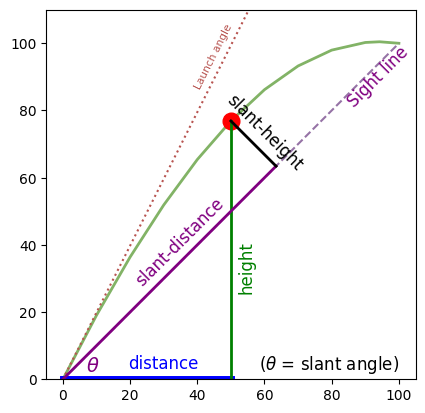

In [10]:
poi = tball.get_at_distance(Distance.Meter(50))
from py_ballisticcalc.visualize.plot import trajectory_as_plot
ax = trajectory_as_plot(tball)
ax.legend().set_visible(False)
ax.set_ylim([0, 110])
ax.set_xlabel('')
ax.set_ylabel('')
for txt in ax.texts:
    if "Launch" in txt.get_text():
        txt.set_position((51, 105))
    if "Sight" in txt.get_text():
        txt.set_color('purple')
        txt.set_fontsize(12)
ax.set_aspect('equal')
distance = poi.distance >> Distance.Meter
height = poi.height >> Distance.Meter
# Point of interest
ax.plot(distance, height, 'o', color='red', markersize=12, label='Target')
# Distance
ax.plot([0, distance], [0, 0], color='blue', linewidth=5)
ax.text(5 + distance / 2, 2, 'distance', color='blue', fontsize=12, ha='center', va='bottom')
# Height
ax.plot([distance, distance], [0, height], color='green', linewidth=2)
ax.text(distance+2, height/2 - 5, 'height', color='green', fontsize=12, rotation=90, va='center', ha='left')
# slant_distance
angle = slant_angle >> Angular.Degree
sine = math.sin(slant_angle >> Angular.Radian)
slant_distance = sine * (poi.slant_distance >> Distance.Meter)
center = (slant_distance) / 2
ax.plot([0, slant_distance], [0, slant_distance], color='purple', linewidth=2)
ax.text(center+3, center-5, 'slant-distance', color='purple', fontsize=12, rotation=angle, ha='center', va='bottom')
# Target drop
slant_height = poi.slant_height >> Distance.Meter
ax.plot([slant_distance, distance], [slant_distance, height], color='black', linewidth=2)
ax.text(10 + slant_distance - sine * slant_height, 10 + height - sine * slant_height, 'slant-height', color='black',
        fontsize=12, rotation=angle-90, va='center', ha='center')
ax.text(7, 1, r'$\theta$', color='purple', fontsize=14, ha='left', va='bottom')
ax.text(100, 1, r'($\theta$ = slant angle)', color='black', fontsize=12, ha='right', va='bottom')
#plt.savefig('slant_terms.svg', bbox_inches='tight')
plt.show()